In [8]:
install.packages('keras',Ncpus = 12)
library(tensorflow)
library(reticulate)
library(tidyverse)
library(ggplot2)
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’



Attaching package: ‘tensorflow’


The following object is masked from ‘package:caret’:

    train


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
✔ purrr   1.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()



# Input data

> The data is downloaded from [STRING](https://string-db.org/cgi/download?sessionId=bDnyqNJkHsBL); The proteins are from homo sapiens.

In [9]:
# X.ncbi_taxid
# cluster_id
# cluster_size
# best_described_by
cluster_info <- read.delim("9606.clusters.info.v11.5.txt",header = T,sep = '\t')

# X.ncbi_taxid
# cluster_id
# protein_id
cluster_protein <- read.delim("9606.clusters.proteins.v11.5.txt",header = T,sep = '\t')

# X.string_protein_1
# preferred_name
# protein_size
# annotation
protein_info <- read.delim("9606.protein.info.v11.5.txt",header =T, sep = '\t')

protein_links_full <- read.table("9606.protein.links.full.v11.5.txt",header =T)


# Read protein sequence information
protein_sequence<- read.table("9606.protein.sequences.v11.5.fa", sep = "\n", stringsAsFactors = FALSE)

# Combine the lines into a single string
lines <- paste(protein_sequence$V1, collapse = " ")

# Split the lines based on the '>' character
components <- strsplit(lines, ">")

# Remove the empty first element
components <- components[[1]][-1]

# Extract protein IDs and sequences
protein_id <- apply(data.frame(components),1,function(x) {
  strsplit(x, "\\s+")[[1]][1]
})

protein_sequence <- apply(data.frame(components),1, function(x) {
  paste(strsplit(x,'\\s+')[[1]][-1],collapse = '')
})

# Create the data frame
sequence <- data.frame(Protein_id = protein_id, Protein_sequence = protein_sequence, stringsAsFactors = FALSE)


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


> Clean data

In [11]:
# remove unnecessary data columns
cluster_info <- cluster_info[,-1]
cluster_protein <- cluster_protein[,-1]
protein_info <- protein_info[,-4]
protein_links <- protein_links_full[,c('protein1','protein2')]
rm(protein_links_full)

# Data sample Generation

> In this part, we choose one protein as one example. The protein id which is chosen is "9606.ENSP00000000233", name is "ARF5". We fix this protein and extract all pairs containing the specified protein. The pair we extract are considered to have strong interactions, which are positive dataset. To obtain negative pairs, proteins with a size equal to the number of positive pairings are selected at random from the remaining proteins.

In [12]:
# set fixed performance
set.seed(1)
positive_pairs <- protein_links[protein_links$protein1=='9606.ENSP00000000233',]
negative_pairs <- data.frame(protein1 = positive_pairs$protein1,
                             protein2 = sample(sequence$Protein_id[
                               !(sequence$Protein_id %in%
                                   positive_pairs$protein2)],
                               size = nrow(positive_pairs)))
dim(positive_pairs) # 1440 * 2
dim(negative_pairs) # 1440 * 2

# Check and make sure positive pairs and negative pairs have no common pairs
sum(positive_pairs$protein2 %in% negative_pairs$protein2)




# Join pairs with the corresponding sequence
positive_pairs <- positive_pairs %>%
  inner_join(sequence, by = c('protein1'='Protein_id')) %>%
  inner_join(sequence, by = c('protein2' = 'Protein_id')) %>%
  rename(sequence1 = Protein_sequence.x, sequence2 = Protein_sequence.y)

negative_pairs <- negative_pairs %>%
  inner_join(sequence, by = c('protein1'='Protein_id')) %>%
  inner_join(sequence, by = c('protein2' = 'Protein_id')) %>%
  rename(sequence1 = Protein_sequence.x, sequence2 = Protein_sequence.y)

[1] 1440    2

[1] 1440    2

[1] 0

## Feature extraction

> In this part, we refer to the [(Shen 2007)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1838603/#:~:text=In%20the%20present%20work%2C%20we%20propose%20a%20method,a%20conjoint%20triad%20feature%20for%20describing%20amino%20acids.) using conjoint traid method in order to convert the sequence into a new feature space.

* Each sequence consists of 20 types of amino acid
* Each amino acid could be categorized into 7 classes
* {A,G,V} -> Class 1
* {I,L,F,P} -> Class 2
* {Y,M,T,S} -> Class 3
* {H,N,Q,W} -> Class 4
* {R,K} -> Class 5
* {D,E} -> Class 6
* {C} -> Class 7

In [13]:
map_sequence <- function(sequence)
{
  sequence <- gsub('A|G|V',1,sequence)
  sequence <- gsub('I|L|F|P',2,sequence)
  sequence <- gsub('Y|M|T|S',3,sequence)
  sequence <- gsub('H|N|Q|W',4,sequence)
  sequence <- gsub('R|K',5,sequence)
  sequence <- gsub('D|E',6,sequence)
  sequence <- gsub('C',7,sequence)
  return(sequence)
}



# map sequence to feature space
positive_feature <- data.frame(sequence1 = positive_pairs$sequence1,
                               sequence2 = positive_pairs$sequence2)

positive_feature$sequence1 <- map_sequence(positive_feature$sequence1)
positive_feature$sequence2 <- map_sequence(positive_feature$sequence2)


negative_feature <- data.frame(sequence1 = negative_pairs$sequence1,
                               sequence2 = negative_pairs$sequence2)
negative_feature$sequence1 <- map_sequence(negative_feature$sequence1)
negative_feature$sequence2 <- map_sequence(negative_feature$sequence2)


# function to convert sequence into normalized frequency vector
# by sliding the 3-unit window from the start to the third from last
one_hot_to_frequency <- function(sequence)
{
  sequence <- strsplit(sequence,'')[[1]]
  sequence_len <- length(sequence)
  one_hot <- numeric(343)
  for(i in 1:(sequence_len-2))
  {
    index <- (as.numeric(sequence[i]) - 1) * 49 + (as.numeric(sequence[i+1]) - 1) * 7 + (as.numeric(sequence[i+2]) - 1) + 1
    one_hot[index] <- one_hot[index]+1
  }
  norm_frequency <- (one_hot-min(one_hot))/max(one_hot)
  return(norm_frequency)
}

# map feature space to normalized feature space
# For each pair, concatenate normalized feature space of protein1 and protein2 to create a final feature vector


# 686 rows, 1440 columns (observations)
positive_norm_feature <- apply(positive_feature,1,
                               function(x) c(one_hot_to_frequency(x[1]),one_hot_to_frequency(x[2])))

negative_norm_feature <- apply(negative_feature,1,
                               function(x) c(one_hot_to_frequency(x[1]),one_hot_to_frequency(x[2])))


Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning message in one_hot_to_frequency(x[2]):
“NAs introduced by coercion”
Warning mess

# Experiment

In [20]:
library(keras)

# Pick up 75% as training dataset, 25% as test dataset
smp_size <- floor(0.75*ncol(positive_norm_feature)) #1440 observations

set.seed(1)
train_positive_ind <- sample(seq_len(ncol(positive_norm_feature)),size = smp_size)

train_positive <- positive_norm_feature[,train_positive_ind]
test_positive <- positive_norm_feature[,-train_positive_ind]



set.seed(2)
train_negative_ind <- sample(seq_len(ncol(negative_norm_feature)),size = smp_size)

train_negative <- negative_norm_feature[,train_negative_ind]
test_negative <- negative_norm_feature[,-train_negative_ind]


train_feature <- cbind(train_positive,train_negative)
test_feature <- cbind(test_positive,test_negative)

train_output <- c(rep(1,1080),rep(0,1080))
test_output <- c(rep(1,360),rep(0,360))




# Initialize neural network model
model <- keras_model_sequential() %>%
    layer_dense(units = 686*2,activation = 'relu',
    input_shape = 686) %>%
    layer_dropout(0.2) %>%
    layer_dense(units = 1,activation = 'sigmoid')


model %>% compile(optimizer = 'nadam',
  loss = 'binary_crossentropy',
  metrics = c('accuracy'))

print_dot_callback <- callback_lambda(
  on_epoch_end = function(epoch, logs) {
    if (epoch %% 80 == 0) cat("\n")
    cat(".")
  }
)

# shuffle the training data
set.seed(10)
shuffle_id <- sample(seq_len(ncol(train_feature)),size = 2160)

model %>% fit(t(train_feature[,shuffle_id]),
train_output[shuffle_id],epochs = 100,
validation_split = 0.2,
callbacks = list(print_dot_callback),
verbose = 2)


score <- model %>%
evaluate(t(test_feature),test_output,verbose = 0)
score


predictions <- predict(model,t(test_feature))



................................................................................
....................

loss  accuracy 
1.7452204 0.6180556

# Results

Setting levels: control = 0, case = 1

Setting direction: controls < cases



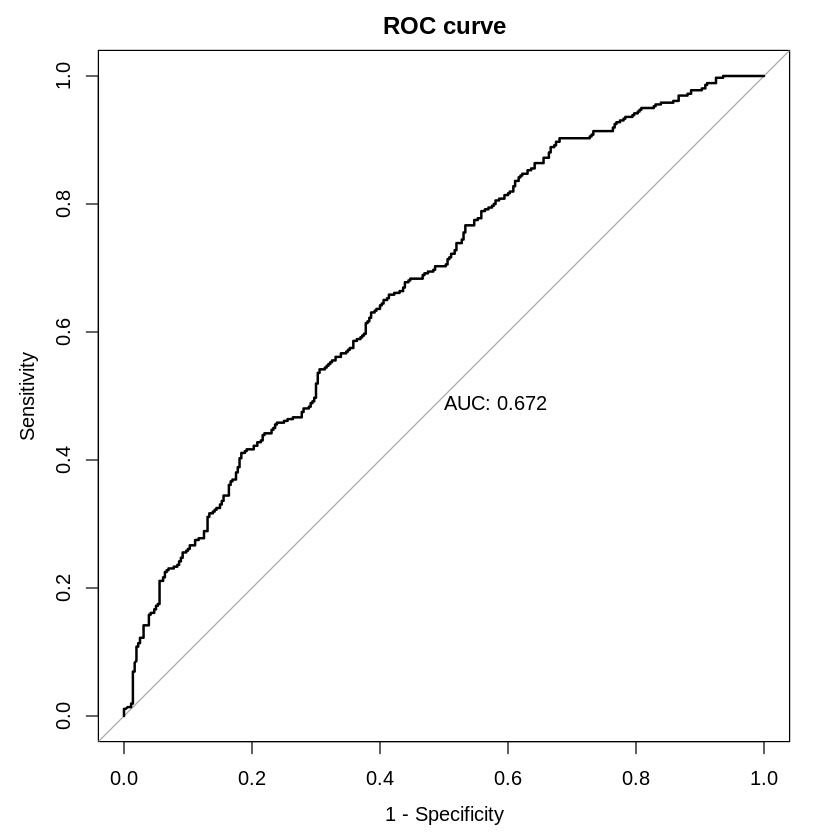

In [24]:
library(pROC)
rocobj <- roc(as.numeric((test_output)),as.numeric(predictions))
plot(rocobj,main = 'ROC curve',print.auc = TRUE,legacy.axes = TRUE)

In [25]:
confusionMatrix(data=as.factor(ifelse(predictions>=0.5,1,0)), reference =as.factor(test_output),positive = '1')

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 223 138
         1 137 222
                                          
               Accuracy : 0.6181          
                 95% CI : (0.5814, 0.6537)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 1.25e-10        
                                          
                  Kappa : 0.2361          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.6167          
            Specificity : 0.6194          
         Pos Pred Value : 0.6184          
         Neg Pred Value : 0.6177          
             Prevalence : 0.5000          
         Detection Rate : 0.3083          
   Detection Prevalence : 0.4986          
      Balanced Accuracy : 0.6181          
                                          
       'Positive' Class : 1               
                              